# Correlation scores for the (dataset, partitioner) pairs

The first (this) section provides the exploration of the correlation of the accuracy (on the final left out set from model train in FL manner) and the heterogeneity metric (hellinger distance) of the partitions (train set).



In [120]:
import pandas as pd
import numpy as np
from IPython.display import display
import dataframe_image as dfi
from typing import Literal
import seaborn as sns

In [126]:
DISPLAY_DATAFRAMES = True
SAVE_DATAFRAMES = False
PLOT_RESULTS = False

In [137]:
res_dict = {}
acc_dict = {}
hetero_dict = {}

corrs = {}

base_acc_path = "/home/FL-heterogeneity/results"
base_hetero_path = "/home/FL-heterogeneity/final-het-results"
hetero_metric = "hellinger_distance" # earths_mover_distance
DS_NAMES = ["mnist", "cifar10", "cifar100", "fashion_mnist"]

In [138]:
acc_cols = {
    "IidPartitioner": ["num_partitions"],
    "DirichletPartitioner": ["num_partitions", "alpha"],
    "PathologicalPartitioner": ["num_partitions", "num_classes_per_partition"],
}


def read_data(
    ds_name,
    partitioner_name,
    base_acc_path=base_acc_path,
    base_hetero_path=base_hetero_path,
    mode: Literal["single-seed", "multi-seed", "mean"] = "multi-seed",
):
    # Read hetero
    path = f"{base_hetero_path}/{ds_name}/{partitioner_name}/compute_{hetero_metric}.csv" if ds_name != "fashion_mnist" else f"{base_hetero_path}/zalando-datasets/{ds_name}/{partitioner_name}/compute_{hetero_metric}.csv"
    metrics = pd.read_csv(path)
    metrics = metrics.drop_duplicates()

    if mode == "single-seed":
        print(metrics.shape)
        hetero = metrics.loc[metrics["fds_seed"] == 42]
        print(hetero.shape)
    elif mode == "multi-seed":
        hetero = metrics
    elif mode == "mean":
        hetero = metrics.groupby(acc_cols[partitioner_name])["metric_value"].mean().to_frame()

    try:
        cols = acc_cols[partitioner_name] + ["metric_value"]
        if mode == "multi-seed":
            cols += ["fds_seed"] 
        hetero = hetero[cols]
    except:
        hetero = hetero[["metric_value"]]
    # Read acc
    path_acc = (
        f"{base_acc_path}/"
        + f"final-{ds_name}/{ds_name}/{partitioner_name}/Adam"
        + "{}"
        + "/test_res.csv"
    ) if ds_name != "fashion_mnist" else f"{base_acc_path}/final-fashion-mnist/zalando-datasets/fashion_mnist/{partitioner_name}/Adam" + "{}" +"/test_res.csv"
    acc = pd.read_csv(path_acc)
    if partitioner_name == "DirichletPartitioner":
        acc = acc[acc["self_balancing"] == False]
    if partitioner_name == "PathologicalPartitioner":
        acc = acc[acc["class_assignment_mode"] == "first-deterministic"]
    
    if mode == "single-seed":
        acc = acc.loc[acc["fds_seed"] == 42]

    acc = acc[acc_cols[partitioner_name] + ["eval/acc"]]
    # Merge results
    res = acc.merge(hetero, on=acc_cols[partitioner_name])
    return res, acc, hetero

def save_acc_results(acc, ds_name, partitioner_name):
    if partitioner_name == "DirichletPartitioner":

        dfi.export(
                    acc.loc[:, acc_cols[partitioner_name] + ["eval/acc"]]
                    .set_index("num_partitions").pivot(columns="alpha")
                    .style.background_gradient(
                        subset="eval/acc", vmin=0, vmax=1, cmap="Greens"
                    ),
                    f"/home/FL-heterogeneity/plots/acc/{hetero_metric}/{ds_name}_{partitioner_name}_test_acc_df.png",
                    table_conversion="matplotlib",
                )
    else:
        dfi.export(
                acc.loc[:, acc_cols[partitioner_name] + ["eval/acc"]]
                .set_index("num_partitions")
                .style.background_gradient(
                    subset="eval/acc", vmin=0, vmax=1, cmap="Greens"
                ),
                f"/home/FL-heterogeneity/plots/acc/{hetero_metric}/{ds_name}_{partitioner_name}_test_acc_df.png",
                table_conversion="matplotlib",
            )

In [145]:
for partitioner_name in ["IidPartitioner", "DirichletPartitioner", "PathologicalPartitioner"]:
    for ds_name in DS_NAMES:
        res, acc, hetero = read_data(ds_name, partitioner_name, mode="multi-seed")
        res_dict[(ds_name, partitioner_name)] = res
        acc_dict[(ds_name, partitioner_name)] = acc
        hetero_dict[(ds_name, partitioner_name)] = hetero
        
    # Compute correlations
    for ds_name in DS_NAMES:
        res = res_dict[(ds_name, partitioner_name)]
        corr = res["eval/acc"].corr(res["metric_value"])
        corrs[(ds_name, partitioner_name)] = corr
        print(f"{ds_name}, {partitioner_name} correlation: {corr}")
    print()


    if DISPLAY_DATAFRAMES:
        for ds_name in DS_NAMES:
            print(f"{ds_name}, {partitioner_name}")
            res = res_dict[(ds_name, partitioner_name)]
            display(res)
    print()

    if PLOT_RESULTS:
        for ds_name in DS_NAMES:
            print(f"{ds_name}, {partitioner_name}")
            res = res_dict[(ds_name, partitioner_name)]
            res[["eval/acc", "metric_value"]].plot(
                kind="scatter",
                x="metric_value",
                y="eval/acc",
                title=f"{partitioner_name}, {ds_name}",
            )

    if SAVE_DATAFRAMES:
        for ds_name in DS_NAMES:
            save_acc_results(acc_dict[(ds_name, partitioner_name)], ds_name, partitioner_name)
            # todo: ? the heterogeneity here too? (where the redder is more homogeneous)


mnist, IidPartitioner correlation: -0.9737852632574456
cifar10, IidPartitioner correlation: -0.8197845168059553
cifar100, IidPartitioner correlation: -0.8636928933004023
fashion_mnist, IidPartitioner correlation: -0.9519957961655253

mnist, IidPartitioner


,num_partitions,eval/acc,metric_value,fds_seed
0,3,0.9913,0.006676,42
1,3,0.9913,0.006054,43
2,3,0.9913,0.006126,44
3,3,0.9913,0.005390,45
4,3,0.9913,0.006087,46
...,...,...,...,...
145,1000,0.9511,0.160275,42
146,1000,0.9511,0.161708,43
147,1000,0.9511,0.156786,44
148,1000,0.9511,0.160886,45


cifar10, IidPartitioner


,num_partitions,eval/acc,metric_value,fds_seed
0,3,0.6059,0.007643,42
1,3,0.6059,0.007258,43
2,3,0.6059,0.006583,44
3,3,0.6059,0.007683,45
4,3,0.6059,0.009727,46
...,...,...,...,...
145,1000,0.4356,0.178303,42
146,1000,0.4356,0.181128,43
147,1000,0.4356,0.177903,44
148,1000,0.4356,0.177688,45


cifar100, IidPartitioner


,num_partitions,eval/acc,metric_value,fds_seed
0,3,0.2693,0.026366,42
1,3,0.2693,0.024042,43
2,3,0.2693,0.025405,44
3,3,0.2693,0.025433,45
4,3,0.2693,0.025627,46
...,...,...,...,...
145,1000,0.0990,0.657551,42
146,1000,0.0990,0.657517,43
147,1000,0.0990,0.657242,44
148,1000,0.0990,0.658027,45


fashion_mnist, IidPartitioner


,num_partitions,eval/acc,metric_value,fds_seed
0,3,0.8934,0.006944,42
1,3,0.8934,0.007138,43
2,3,0.8934,0.006533,44
3,3,0.8934,0.008473,45
4,3,0.8934,0.007756,46
...,...,...,...,...
145,1000,0.7904,0.160471,42
146,1000,0.7904,0.160139,43
147,1000,0.7904,0.158980,44
148,1000,0.7904,0.158301,45



mnist, DirichletPartitioner correlation: -0.28355537980618445
cifar10, DirichletPartitioner correlation: -0.6303945662927642
cifar100, DirichletPartitioner correlation: -0.7566445655826814
fashion_mnist, DirichletPartitioner correlation: -0.585182365041088

mnist, DirichletPartitioner


,num_partitions,alpha,eval/acc,metric_value,fds_seed
0,3,0.1,0.8843,0.466509,42
1,3,0.1,0.8843,0.568080,42
2,3,0.1,0.8843,0.497692,43
3,3,0.1,0.8843,0.541784,43
4,3,0.1,0.8843,0.555117,44
...,...,...,...,...,...
2095,1000,1000.0,0.9471,0.074701,44
2096,1000,1000.0,0.9471,0.075274,45
2097,1000,1000.0,0.9471,0.075274,45
2098,1000,1000.0,0.9471,0.075635,46


cifar10, DirichletPartitioner


,num_partitions,alpha,eval/acc,metric_value,fds_seed
0,3,0.1,0.4992,0.465194,42
1,3,0.1,0.4992,0.568029,42
2,3,0.1,0.4992,0.499886,43
3,3,0.1,0.4992,0.543927,43
4,3,0.1,0.4992,0.558077,44
...,...,...,...,...,...
2095,1000,1000.0,0.4181,0.082791,44
2096,1000,1000.0,0.4181,0.081143,45
2097,1000,1000.0,0.4181,0.081143,45
2098,1000,1000.0,0.4181,0.082502,46


cifar100, DirichletPartitioner


,num_partitions,alpha,eval/acc,metric_value,fds_seed
0,3,0.1,0.0963,0.549485,42
1,3,0.1,0.0963,0.554562,42
2,3,0.1,0.0963,0.531252,43
3,3,0.1,0.0963,0.547337,43
4,3,0.1,0.0963,0.557247,44
...,...,...,...,...,...
2095,1000,1000.0,NaN,NaN,44
2096,1000,1000.0,NaN,NaN,45
2097,1000,1000.0,NaN,NaN,45
2098,1000,1000.0,NaN,NaN,46


fashion_mnist, DirichletPartitioner


,num_partitions,alpha,eval/acc,metric_value,fds_seed
0,3,0.1,0.7427,0.466277,42
1,3,0.1,0.7427,0.567263,42
2,3,0.1,0.7427,0.498822,43
3,3,0.1,0.7427,0.542484,43
4,3,0.1,0.7427,0.557283,44
...,...,...,...,...,...
2095,1000,1000.0,0.7944,0.073702,44
2096,1000,1000.0,0.7944,0.074840,45
2097,1000,1000.0,0.7944,0.074840,45
2098,1000,1000.0,0.7944,0.074420,46



mnist, PathologicalPartitioner correlation: -0.6374083628318594
cifar10, PathologicalPartitioner correlation: -0.7694555560883449
cifar100, PathologicalPartitioner correlation: -0.708075742970956
fashion_mnist, PathologicalPartitioner correlation: -0.7291237321342986

mnist, PathologicalPartitioner


,num_partitions,num_classes_per_partition,eval/acc,metric_value,fds_seed
0,3,0.1,0.1135,0.649356,42
1,3,0.1,0.1135,0.649356,42
2,3,0.1,0.1135,0.649967,42
3,3,0.1,0.1135,0.649356,43
4,3,0.1,0.1135,0.649356,43
...,...,...,...,...,...
4045,1000,0.9,0.9506,0.236619,45
4046,1000,0.9,0.9506,0.237081,45
4047,1000,0.9,0.9506,0.236618,46
4048,1000,0.9,0.9506,0.236602,46


cifar10, PathologicalPartitioner


,num_partitions,num_classes_per_partition,eval/acc,metric_value,fds_seed
0,3,0.1,0.1101,0.650115,42
1,3,0.1,0.1101,0.650115,42
2,3,0.1,0.1101,0.650115,42
3,3,0.1,0.1101,0.650115,43
4,3,0.1,0.1101,0.650115,43
...,...,...,...,...,...
4045,1000,0.9,0.4504,0.238394,45
4046,1000,0.9,0.4504,0.238273,45
4047,1000,0.9,0.4504,0.238508,46
4048,1000,0.9,0.4504,0.238083,46


cifar100, PathologicalPartitioner


,num_partitions,num_classes_per_partition,eval/acc,metric_value,fds_seed
0,3,0.1,0.0626,0.643586,42
1,3,0.1,0.0626,0.319976,42
2,3,0.1,0.0626,0.636728,42
3,3,0.1,0.0626,0.631658,43
4,3,0.1,0.0626,0.319758,43
...,...,...,...,...,...
4045,1000,0.9,NaN,NaN,45
4046,1000,0.9,NaN,NaN,45
4047,1000,0.9,NaN,NaN,46
4048,1000,0.9,NaN,NaN,46


fashion_mnist, PathologicalPartitioner


,num_partitions,num_classes_per_partition,eval/acc,metric_value,fds_seed
0,3,0.1,0.1000,0.650115,42
1,3,0.1,0.1000,0.650115,42
2,3,0.1,0.1000,0.650115,42
3,3,0.1,0.1000,0.650115,43
4,3,0.1,0.1000,0.650115,43
...,...,...,...,...,...
4045,1000,0.9,0.7684,0.236407,45
4046,1000,0.9,0.7684,0.236928,45
4047,1000,0.9,0.7684,0.236407,46
4048,1000,0.9,0.7684,0.236332,46


## Overview of the Correlation for (Dataset, Partitioner) pairs

In [146]:
df = pd.DataFrame(
    list(corrs.values()),
    index=pd.MultiIndex.from_tuples(corrs.keys()),
    columns=["Value"],
)
df.sort_index().style.background_gradient(cmap="RdYlGn", vmin=-1, vmax=1)

## Overview of the Correlation for (Partitioner, Dataset) pairs

It's a column reordering version of the results above

In [147]:
df = df.reorder_levels([1, 0])
df.sort_index().style.background_gradient(cmap="RdYlGn", vmin=-1, vmax=1)

# Cross Partitioners Comparision Plots

Is there a way of infering acc from training from one partitioning scheme based on the heterogeneity metrics.

## Plotting alone

In [148]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

mnist


/tmp/ipykernel_2214306/2070935301.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"


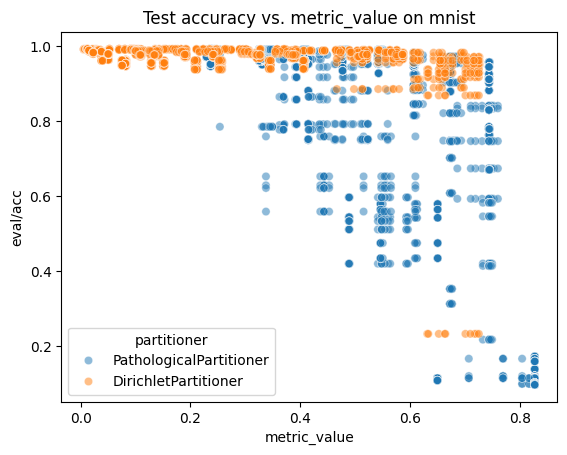

cifar10


/tmp/ipykernel_2214306/2070935301.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"


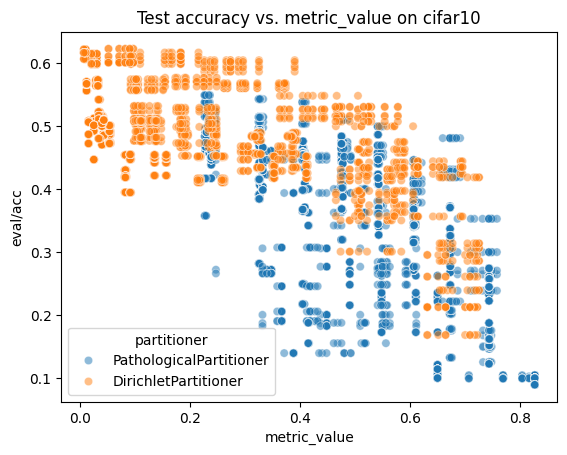

cifar100


/tmp/ipykernel_2214306/2070935301.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathological_df["partitioner"] = p2
/tmp/ipykernel_2214306/2070935301.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"


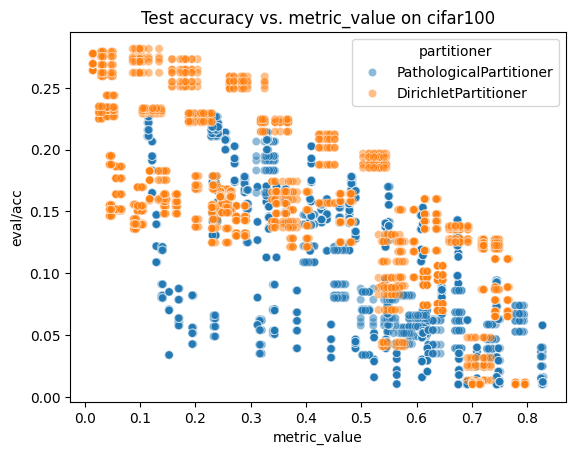

fashion_mnist


/tmp/ipykernel_2214306/2070935301.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"


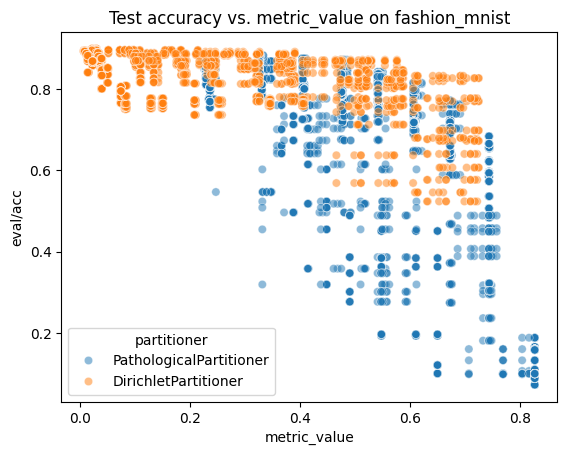

/tmp/ipykernel_2214306/2070935301.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"
/tmp/ipykernel_2214306/2070935301.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"


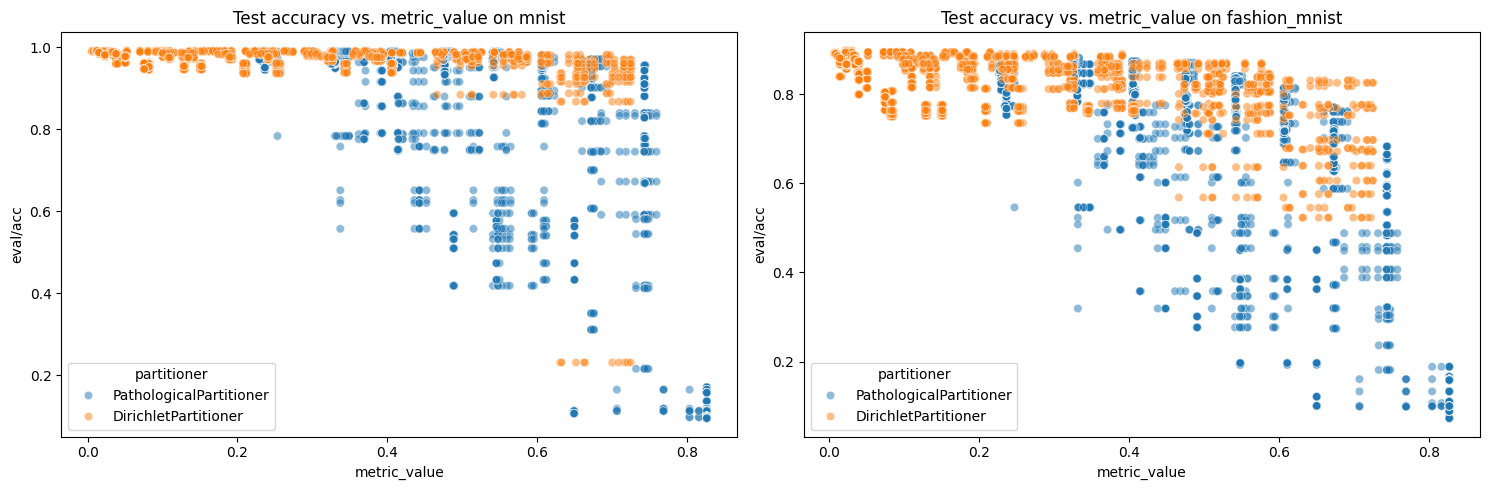

/tmp/ipykernel_2214306/2070935301.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"
/tmp/ipykernel_2214306/2070935301.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"
/tmp/ipykernel_2214306/2070935301.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

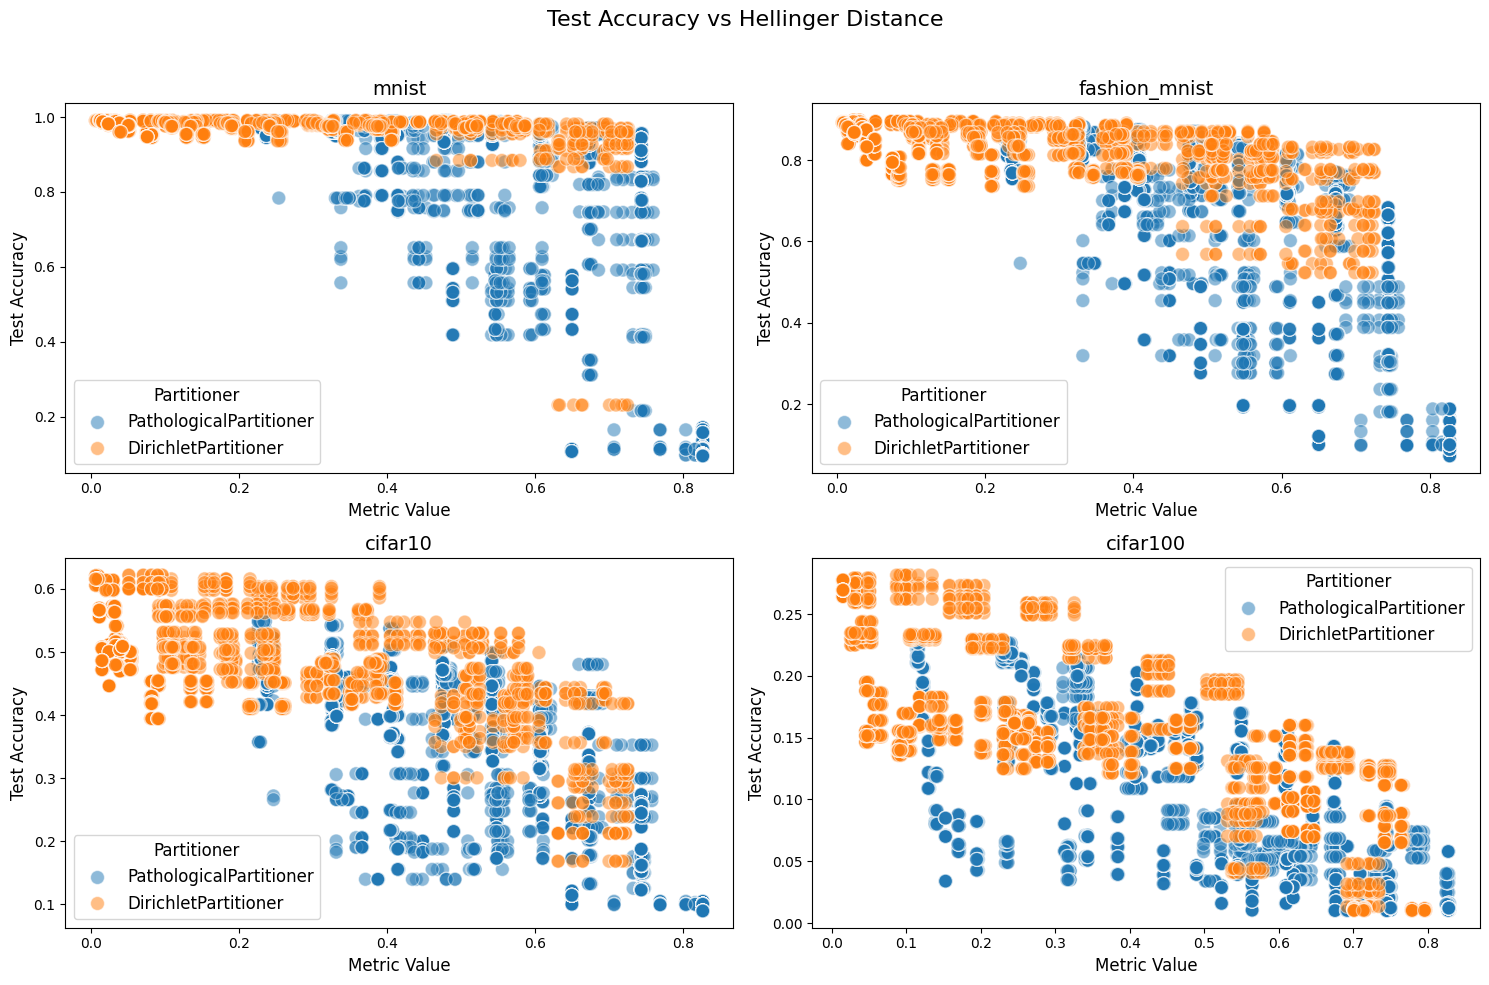

In [149]:
for dataset_name in DS_NAMES:
    print(dataset_name)
    p2 = "PathologicalPartitioner"
    pathological_df = res_dict[(dataset_name, p2)].dropna()
    dirichlet_df = res_dict[(dataset_name, "DirichletPartitioner")].dropna()
    pathological_df["partitioner"] = p2
    dirichlet_df["partitioner"] = "DirichletPartitioner"
    df = pd.concat([pathological_df, dirichlet_df])[
        ["metric_value", "eval/acc", "partitioner"]
    ]
    df

    sns.scatterplot(data=df, x="metric_value", y="eval/acc", hue="partitioner", alpha=0.5)
    plt.title(f"Test accuracy vs. metric_value on {dataset_name}")
    plt.savefig(f"/home/FL-heterogeneity/plots/acc_vs_het/{hetero_metric}/{dataset_name}_test_acc_vs_metric_value.png")
    plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, dataset_name in zip(axes, ["mnist", "fashion_mnist"]):
    p2 = "PathologicalPartitioner"
    pathological_df = res_dict[(dataset_name, p2)].dropna()
    dirichlet_df = res_dict[(dataset_name, "DirichletPartitioner")].dropna()
    pathological_df["partitioner"] = p2
    dirichlet_df["partitioner"] = "DirichletPartitioner"
    df = pd.concat([pathological_df, dirichlet_df])[
        ["metric_value", "eval/acc", "partitioner"]
    ]
    
    sns.scatterplot(data=df, x="metric_value", y="eval/acc", hue="partitioner", alpha=0.5, ax=ax)
    ax.set_title(f"Test accuracy vs. metric_value on {dataset_name}")

plt.tight_layout()
# plt.savefig(f"/home/FL-heterogeneity/plots/acc_vs_het/{hetero_metric}/mnist_fashion_mnist_test_acc_vs_metric_value.png")
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for ax, dataset_name in zip(axes.flatten(), ["mnist", "fashion_mnist", "cifar10", "cifar100"]):
    p2 = "PathologicalPartitioner"
    pathological_df = res_dict[(dataset_name, p2)].dropna()
    dirichlet_df = res_dict[(dataset_name, "DirichletPartitioner")].dropna()
    pathological_df["partitioner"] = p2
    dirichlet_df["partitioner"] = "DirichletPartitioner"
    df = pd.concat([pathological_df, dirichlet_df])[
        ["metric_value", "eval/acc", "partitioner"]
    ]
    
    sns.scatterplot(data=df, x="metric_value", y="eval/acc", hue="partitioner", alpha=0.5, ax=ax, s=100)
    ax.set_title(f"{dataset_name}", fontsize=14)
    ax.set_xlabel("Metric Value", fontsize=12)
    ax.set_ylabel("Test Accuracy", fontsize=12)
    ax.legend(title="Partitioner", fontsize=12, title_fontsize=12)
    ax.grid(False)

plt.suptitle(f"""Test Accuracy vs {'Hellinger Distance' if hetero_metric == 'hellinger_distance' else "Earth Mover's Distance"}""", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"/home/FL-heterogeneity/plots/acc_vs_het/{hetero_metric}/all_datasets_test_acc_vs_metric_value.png", dpi=300)
plt.show()

# Cross partitioner computation

## First try

In [150]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns


iid_df = res_dict[("cifar10", "IidPartitioner")].dropna()
iid_df["partitioner"] = "IidPartitioner"
pathological_df = res_dict[("cifar10", "PathologicalPartitioner")].dropna()
dirichlet_df = res_dict[("cifar10", "DirichletPartitioner")].dropna()
pathological_df["partitioner"] = "PathologicalPartitioner"
dirichlet_df["partitioner"] = "DirichletPartitioner"
df = pd.concat([iid_df, pathological_df, dirichlet_df])[
    ["metric_value", "eval/acc", "partitioner"]
]

# 2. Encode the Group variable
encoder = OneHotEncoder(
    categories=[["IidPartitioner", "DirichletPartitioner", "PathologicalPartitioner"]],
    drop="first",
    sparse_output=False,
)
group_encoded = encoder.fit_transform(df[["partitioner"]])
encoded_feature_names = encoder.get_feature_names_out(["partitioner"])
df_group_encoded = pd.DataFrame(group_encoded, columns=encoded_feature_names)
df_encoded = pd.concat([df.reset_index(drop=True), df_group_encoded], axis=1)
# df_encoded.drop('partitioner', axis=1, inplace=True)

# Create interaction terms manually
for col in encoded_feature_names:
    df_encoded[f"metric_value * {col}"] = df_encoded["metric_value"] * df_encoded[col]

# Define the feature matrix X and target vector y
X = df_encoded[
    ["metric_value"]
    + list(encoded_feature_names)
    + [f"metric_value * {col}" for col in encoded_feature_names]
]
y = df_encoded["eval/acc"]

# Add a constant term to the model (intercept)
X = sm.add_constant(X)

# Fit the linear regression model using statsmodels
model = sm.OLS(y, X).fit()

# Print the summary, which includes p-values, t-values, and other important metrics
print(model.summary())

# # 3. Create interaction terms
# X = df_encoded[['metric_value'] + list(encoded_feature_names)]
# y = df_encoded['eval/acc']
# poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
# X_poly = poly.fit_transform(X)
# feature_names = poly.get_feature_names_out(['metric_value'] + list(encoded_feature_names))
# df_features = pd.DataFrame(X_poly, columns=feature_names)
# df_final = pd.concat([df_features, y.reset_index(drop=True)], axis=1)

# # # 4. Prepare feature matrix and target vector
# # X = df_features.drop(['Group_Experiment 2 Group_Experiment 3'], axis=1)
# X = df_features
# y = df_final['eval/acc']

# # 5. Split the data (optional)
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0, random_state=42)
# X_train, y_train = X, y

# # 6. Fit the Linear Regression model
# model = LinearRegression()
# model.fit(X_train, y_train)

# # 7. Print coefficients
# coefficients = pd.DataFrame({
#     'Feature': X.columns,
#     'Coefficient': model.coef_
# })
# print(coefficients)
# print(f"Intercept: {model.intercept_}")

# # 8. Evaluate the model
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# print(f"Mean Squared Error: {mse:.4f}")
# print(f"R^2 Score: {r2:.4f}")

# # 9. Visualize the results
# colors = {'Experiment 1': 'blue', 'Experiment 2': 'green', 'Experiment 3': 'red'}
# plt.figure(figsize=(10, 6))
# for grp in df['Group'].unique():
#     idx = df['Group'] == grp
#     plt.scatter(df.loc[idx, 'Metric_A'], df.loc[idx, 'eval/acc'], label=grp, color=colors[grp])
#     metric_a_range = np.linspace(df['Metric_A'].min(), df['Metric_A'].max(), 100)
#     group_encoded = encoder.transform([[grp]]).flatten()
#     group_experiment_2 = group_encoded[0] if 'Group_Experiment 2' in encoded_feature_names else 0
#     group_experiment_3 = group_encoded[1] if 'Group_Experiment 3' in encoded_feature_names else 0
#     metric_a_group_2 = metric_a_range * group_experiment_2
#     metric_a_group_3 = metric_a_range * group_experiment_3
#     X_plot = pd.DataFrame({
#         'Metric_A': metric_a_range,
#         'Group_Experiment 2': group_experiment_2,
#         'Group_Experiment 3': group_experiment_3,
#         'Metric_A Group_Experiment 2': metric_a_group_2,
#         'Metric_A Group_Experiment 3': metric_a_group_3
#     })
#     y_plot = model.predict(X_plot)
#     plt.plot(metric_a_range, y_plot, color=colors[grp], label=f'Fitted Line {grp}')
# plt.xlabel('Metric A')
# plt.ylabel('Metric B')
# plt.title('Linear Regression with Interaction Terms (Three Groups)')
# plt.legend()
# plt.show()

                            OLS Regression Results                            
Dep. Variable:               eval/acc   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     2597.
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:26:08   Log-Likelihood:                 6959.9
No. Observations:                6150   AIC:                        -1.391e+04
Df Residuals:                    6144   BIC:                        -1.387e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

/tmp/ipykernel_2214306/3308329796.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"


## As fnc

In [60]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm


def cmp_two_partitioners(p1, p2, dataset_name):
    print(f"Dataset: {dataset_name}")
    iid_df = res_dict[(dataset_name, "IidPartitioner")].dropna()
    iid_df["partitioner"] = "IidPartitioner"
    pathological_df = res_dict[(dataset_name, "PathologicalPartitioner")].dropna()
    dirichlet_df = res_dict[(dataset_name, "DirichletPartitioner")].dropna()
    pathological_df["partitioner"] = "PathologicalPartitioner"
    dirichlet_df["partitioner"] = "DirichletPartitioner"
    to_concat = []
    if p1 == "IidPartitioner":
        to_concat.append(iid_df)
    elif p1 == "PathologicalPartitioner":
        to_concat.append(pathological_df)
    elif p1 == "DirichletPartitioner":
        to_concat.append(dirichlet_df)
    if p2 == "IidPartitioner":
        to_concat.append(iid_df)
    elif p2 == "PathologicalPartitioner":
        to_concat.append(pathological_df)
    elif p2 == "DirichletPartitioner":
        to_concat.append(dirichlet_df)
    df = pd.concat(to_concat)[
        ["metric_value", "eval/acc", "partitioner"]
    ]
    # 2. Encode the Group variable
    encoder = OneHotEncoder(
        categories=[[p1, p2]],
        drop="first",
        sparse_output=False,
    )
    group_encoded = encoder.fit_transform(df[["partitioner"]])
    encoded_feature_names = encoder.get_feature_names_out(["partitioner"])
    df_group_encoded = pd.DataFrame(group_encoded, columns=encoded_feature_names)
    df_encoded = pd.concat([df.reset_index(drop=True), df_group_encoded], axis=1)
    # df_encoded.drop('partitioner', axis=1, inplace=True)

    # Create interaction terms manually
    for col in encoded_feature_names:
        df_encoded[f"metric_value * {col}"] = (
            df_encoded["metric_value"] * df_encoded[col]
        )

    # Define the feature matrix X and target vector y
    X = df_encoded[
        ["metric_value"]
        + list(encoded_feature_names)
        + [f"metric_value * {col}" for col in encoded_feature_names]
    ]
    y = df_encoded["eval/acc"]

    # Add a constant term to the model (intercept)
    X = sm.add_constant(X)

    # Fit the linear regression model using statsmodels
    model = sm.OLS(y, X).fit()

    # Print the summary, which includes p-values, t-values, and other important metrics
    print(model.summary())

    # sns.scatterplot(data=df, x="metric_value", y="eval/acc", hue="partitioner")
    # plt.title(
    #     f"Scatter plot of eval/acc vs. metric_value by partitioner on {dataset_name}"
    # )
    # plt.show()
    return model.summary()

In [62]:
summaries = {}


In [63]:
cmp_two_partitioners("IidPartitioner", "DirichletPartitioner", "cifar10")

Dataset: cifar10
                            OLS Regression Results                            
Dep. Variable:               eval/acc   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     443.5
Date:                Tue, 03 Dec 2024   Prob (F-statistic):          3.11e-204
Time:                        10:26:22   Log-Likelihood:                 1973.5
No. Observations:                1450   AIC:                            -3939.
Df Residuals:                    1446   BIC:                            -3918.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

/tmp/ipykernel_1855844/1948221739.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               eval/acc   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     443.5
Date:                Tue, 03 Dec 2024   Prob (F-statistic):          3.11e-204
Time:                        10:26:22   Log-Likelihood:                 1973.5
No. Observations:                1450   AIC:                            -3939.
Df Residuals:                    1446   BIC:                            -3918.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                                               0.5698      0.008     69.313      0.000       0.554       0.586
metric_value                                       -0.8532      0.096     -8.896      0.000      -1.041      -0.665
partitioner_DirichletPartitioner                   -0.0092      0.009     -1.067      0.286      -0.026       0.008
metric_value * partitioner_DirichletPartitioner     0.5736      0.096      5.960      0.000       0.385       0.762
==============================================================================
Omnibus:                        6.376   Durbin-Watson:                   0.113
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                6.374
Skew:                          -0.145   Prob(JB):                       0.0413
Kurtosis:                       2.855   Cond. No.                         118.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
summaries["cifar10"] = cmp_two_partitioners("DirichletPartitioner", "PathologicalPartitioner", "cifar10")

Dataset: cifar10
                            OLS Regression Results                            
Dep. Variable:               eval/acc   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     3538.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:26:35   Log-Likelihood:                 4586.2
No. Observations:                3760   AIC:                            -9164.
Df Residuals:                    3756   BIC:                            -9139.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

/tmp/ipykernel_1855844/1948221739.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"


In [76]:
summaries["cifar100"] = cmp_two_partitioners("DirichletPartitioner", "PathologicalPartitioner", "cifar100")

Dataset: cifar100
                            OLS Regression Results                            
Dep. Variable:               eval/acc   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     4566.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        11:16:25   Log-Likelihood:                 10501.
No. Observations:                5625   AIC:                        -2.099e+04
Df Residuals:                    5621   BIC:                        -2.097e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/tmp/ipykernel_1855844/1948221739.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathological_df["partitioner"] = "PathologicalPartitioner"
/tmp/ipykernel_1855844/1948221739.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"


In [77]:
summaries["mnist"] = cmp_two_partitioners("DirichletPartitioner", "PathologicalPartitioner", "mnist")

Dataset: mnist
                            OLS Regression Results                            
Dep. Variable:               eval/acc   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     1714.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        11:16:42   Log-Likelihood:                 1715.5
No. Observations:                4800   AIC:                            -3423.
Df Residuals:                    4796   BIC:                            -3397.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

/tmp/ipykernel_1855844/1948221739.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"


In [57]:
cmp_two_partitioners("IidPartitioner", "PathologicalPartitioner", "cifar10")

Dataset: cifar10
                            OLS Regression Results                            
Dep. Variable:               eval/acc   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     2062.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:18:52   Log-Likelihood:                 3035.1
No. Observations:                2550   AIC:                            -6062.
Df Residuals:                    2546   BIC:                            -6039.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

/tmp/ipykernel_1855844/52307897.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"


### Extract data from summaries

In [ ]:
summaries["cifar10"]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               eval/acc   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     3538.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:26:35   Log-Likelihood:                 4586.2
No. Observations:                3760   AIC:                            -9164.
Df Residuals:                    3756   BIC:                            -9139.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
const                                                  0.5606      0.003    185.964      0.000       0.555       0.567
metric_value                                          -0.2796      0.009    -30.497      0.000      -0.298      -0.262
partitioner_PathologicalPartitioner                    0.0999      0.005     18.529      0.000       0.089       0.110
metric_value * partitioner_PathologicalPartitioner    -0.3175      0.012    -26.319      0.000      -0.341      -0.294
==============================================================================
Omnibus:                      161.875   Durbin-Watson:                   0.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.505
Skew:                          -0.478   Prob(JB):                     9.57e-43
Kurtosis:                       3.567   Cond. No.                         17.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [130]:
# Initialize an empty list to store the extracted data
extracted_data_list = []
r_squared_list = []

# Iterate over the datasets in the summaries object
for dataset in ["cifar10", "cifar100", "mnist"]:
    summary = summaries[dataset]
    coefficients = summary.tables[1].data[1:]  # Skip the header row
    for row in coefficients:
        extracted_data_list.append({
            "dataset": dataset,
            "coefficient": row[0],
            "value": float(row[1]),
            "std_err": float(row[2]),
            "t_value": float(row[3]),
            "p_value": float(row[4]),
            "conf_lower": float(row[5]),
            "conf_upper": float(row[6])
        })
    r_squared = float(summary.tables[0].data[0][3].split()[0])  # Extract R-squared value
    r_squared_list.append({
        "dataset": dataset,
        "r_squared": r_squared
    })

# Convert the lists to pandas dataframes
extracted_df = pd.DataFrame(extracted_data_list)
r_squared_df = pd.DataFrame(r_squared_list)

# Set multiindex for the extracted_df
extracted_df.set_index(['dataset', 'coefficient'], inplace=True)

# Display the dataframes
print(extracted_df)
print(r_squared_df)
# summary = summaries["cifar10"]
# coefficients = summary.tables[1].data[1:]  # Skip the header row
# extracted_data = {row[0]: float(row[1]) for row in coefficients}
# r_squared = float(summary.tables[0].data[3][3].split()[0])  # Extract R-squared value
# # Extracting p-values from the summary
# p_values = {row[0]: float(row[4]) for row in coefficients}

# print("Extracted Coefficients:", extracted_data)
# print("R-squared:", r_squared)
# print("P-values:", p_values)

                                                              value  std_err  \
dataset  coefficient                                                           
cifar10  const                                               0.5606    0.003   
         metric_value                                       -0.2796    0.009   
         partitioner_PathologicalPartitioner                 0.0999    0.005   
         metric_value * partitioner_PathologicalPartitioner -0.3175    0.012   
cifar100 const                                               0.2326    0.001   
         metric_value                                       -0.2119    0.003   
         partitioner_PathologicalPartitioner                 0.0305    0.002   
         metric_value * partitioner_PathologicalPartitioner -0.0749    0.005   
mnist    const                                               0.9863    0.007   
         metric_value                                       -0.0538    0.020   
         partitioner_PathologicalPartiti

In [131]:
pivot_df = extracted_df.reset_index().pivot(index='coefficient', columns='dataset', values=['value'])
# pivot_df.style.background_gradient(subset=[('value', 'mnist'), ('value', 'cifar10'), ('value', 'cifar100'), ], cmap="RdYlGn")
pivot_df.columns = pivot_df.columns.droplevel(0)
# Rename the coefficients
pivot_df.rename(index={
    'const': 'beta_0',
    'metric_value': 'beta_1',
    'partitioner_PathologicalPartitioner': 'delta',
    'metric_value * partitioner_PathologicalPartitioner': 'gamma'
}, inplace=True)
# Format the coefficient names with LaTeX symbols
pivot_df = pivot_df.reindex(['beta_0', 'beta_1', 'gamma', 'delta'])
pivot_df.rename(index={
    'beta_0': r'$\beta_0$',
    'beta_1': r'$\beta_1$',
    'delta': r'$\delta$',
    'gamma': r'$\gamma$'
}, inplace=True)

pivot_df
latex_table = pivot_df.to_latex(escape=False, caption="Coefficients for Different Datasets", label="tab:coefficients", index_names=False, column_format="lrrr").replace("\\toprule", "\\hline").replace("\\midrule", "\\hline").replace("\\bottomrule", "\\hline")
print(latex_table)
dfi.export(pivot_df,  table_conversion="matplotlib", filename="/home/FL-heterogeneity/plots/acc_vs_het/coefficients.png")


\begin{table}
\caption{Coefficients for Different Datasets}
\label{tab:coefficients}
\begin{tabular}{lrrr}
\hline
dataset & cifar10 & cifar100 & mnist \\
\hline
$\beta_0$ & 0.560600 & 0.232600 & 0.986300 \\
$\beta_1$ & -0.279600 & -0.211900 & -0.053800 \\
$\gamma$ & -0.317500 & -0.074900 & -0.992400 \\
$\delta$ & 0.099900 & 0.030500 & 0.393200 \\
\hline
\end{tabular}
\end{table}



/root/.pyenv/versions/3.10.9/envs/fl-heterogeneity/lib/python3.10/site-packages/dataframe_image/converter/matplotlib_table.py:147: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not thead and not tbody:


In [132]:
extracted_df

value  std_err  \
dataset  coefficient                                                           
cifar10  const                                               0.5606    0.003   
         metric_value                                       -0.2796    0.009   
         partitioner_PathologicalPartitioner                 0.0999    0.005   
         metric_value * partitioner_PathologicalPartitioner -0.3175    0.012   
cifar100 const                                               0.2326    0.001   
         metric_value                                       -0.2119    0.003   
         partitioner_PathologicalPartitioner                 0.0305    0.002   
         metric_value * partitioner_PathologicalPartitioner -0.0749    0.005   
mnist    const                                               0.9863    0.007   
         metric_value                                       -0.0538    0.020   
         partitioner_PathologicalPartitioner                 0.3932    0.011   
         metric_value * partitioner_PathologicalPartitioner -0.9924    0.026   

                                                             t_value  p_value  \
dataset  coefficient                                                            
cifar10  const                                               185.964    0.000   
         metric_value                                        -30.497    0.000   
         partitioner_PathologicalPartitioner                  18.529    0.000   
         metric_value * partitioner_PathologicalPartitioner  -26.319    0.000   
cifar100 const                                               156.518    0.000   
         metric_value                                        -60.891    0.000   
         partitioner_PathologicalPartitioner                  12.253    0.000   
         metric_value * partitioner_PathologicalPartitioner  -15.412    0.000   
mnist    const                                               150.654    0.000   
         metric_value                                         -2.646    0.008   
         partitioner_PathologicalPartitioner                  34.921    0.000   
         metric_value * partitioner_PathologicalPartitioner  -38.289    0.000   

                                                             conf_lower  \
dataset  coefficient                                                      
cifar10  const                                                    0.555   
         metric_value                                            -0.298   
         partitioner_PathologicalPartitioner                      0.089   
         metric_value * partitioner_PathologicalPartitioner      -0.341   
cifar100 const                                                    0.230   
         metric_value                                            -0.219   
         partitioner_PathologicalPartitioner                      0.026   
         metric_value * partitioner_PathologicalPartitioner      -0.084   
mnist    const                                                    0.974   
         metric_value                                            -0.094   
         partitioner_PathologicalPartitioner                      0.371   
         metric_value * partitioner_PathologicalPartitioner      -1.043   

                                                             conf_upper  
dataset  coefficient                                                     
cifar10  const                                                    0.567  
         metric_value                                            -0.262  
         partitioner_PathologicalPartitioner                      0.110  
         metric_value * partitioner_PathologicalPartitioner      -0.294  
cifar100 const                                                    0.236  
         metric_value                                            -0.205  
         partitioner_PathologicalPartitioner                      0.035  
         metric_value * partitioner_PathologicalPartitioner      -0.065  
mnist    const 

In [143]:
r_squared_df
latex_r_squared_table = r_squared_df.to_latex(index=False, caption="R-squared Values for Different Datasets", label="tab:r_squared", column_format="lr", float_format="%.3f")
latex_r_squared_table = latex_r_squared_table.replace("\\begin{table}", "\\begin{table}\n\\begin{center}").replace("\\end{table}", "\\end{center}\n\\end{table}").replace("\\toprule", "\\hline").replace("\\midrule", "\\hline").replace("\\bottomrule", "\\hline")
print(latex_r_squared_table)

\begin{table}
\begin{center}
\caption{R-squared Values for Different Datasets}
\label{tab:r_squared}
\begin{tabular}{lr}
\hline
dataset & r_squared \\
\hline
cifar10 & 0.739 \\
cifar100 & 0.709 \\
mnist & 0.517 \\
\hline
\end{tabular}
\end{center}
\end{table}



Dataset: cifar10
                            OLS Regression Results                            
Dep. Variable:               eval/acc   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     78.30
Date:                Wed, 23 Oct 2024   Prob (F-statistic):           7.94e-29
Time:                        13:15:02   Log-Likelihood:                 153.39
No. Observations:                 132   AIC:                            -298.8
Df Residuals:                     128   BIC:                            -287.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

/tmp/ipykernel_1178096/2959293513.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"


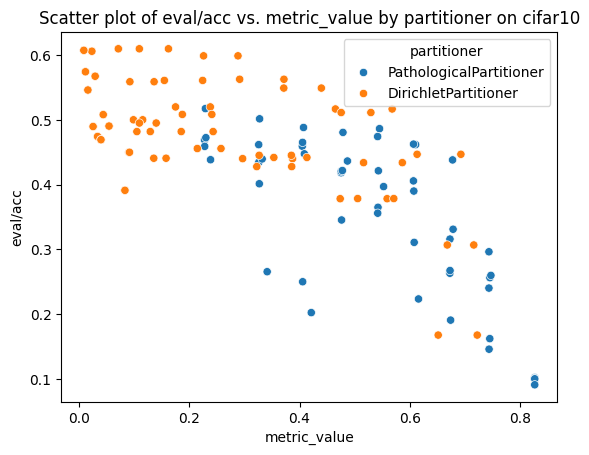

In [64]:
dir_vs_path("cifar10")

Dataset: cifar100
                            OLS Regression Results                            
Dep. Variable:               eval/acc   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     75.20
Date:                Wed, 23 Oct 2024   Prob (F-statistic):           1.08e-27
Time:                        13:15:27   Log-Likelihood:                 222.13
No. Observations:                 127   AIC:                            -436.3
Df Residuals:                     123   BIC:                            -424.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/tmp/ipykernel_1178096/2959293513.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathological_df["partitioner"] = "PathologicalPartitioner"
/tmp/ipykernel_1178096/2959293513.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df["partitioner"] = "DirichletPartitioner"


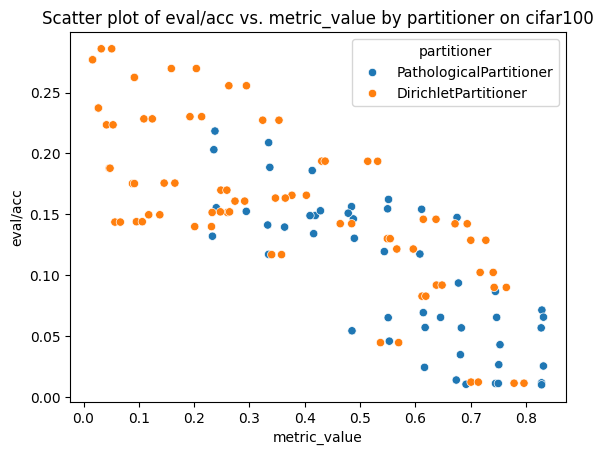

In [65]:
dir_vs_path("cifar100")

# Learn how to do cross partitioner comparison

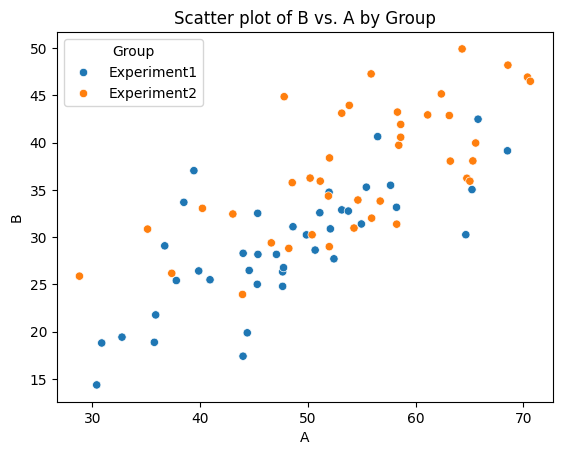

               sum_sq    df          F        PR(>F)
Group      409.070568   1.0  18.709565  4.570192e-05
A         1763.130254   1.0  80.639878  1.458166e-13
A:Group      0.237501   1.0   0.010863  9.172666e-01
Residual  1661.682822  76.0        NaN           NaN
Interaction not significant. Proceeding without interaction term.
               sum_sq    df          F        PR(>F)
Group      409.070568   1.0  18.953035  4.074290e-05
A         1763.130254   1.0  81.689253  1.012162e-13
Residual  1661.920322  77.0        NaN           NaN
                            OLS Regression Results                            
Dep. Variable:                      B   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     72.25
Date:                Mon, 23 Sep 2024   Prob (F-statistic):           2.16e-18
Time:                        10:22:45   Log-Likelihood:       

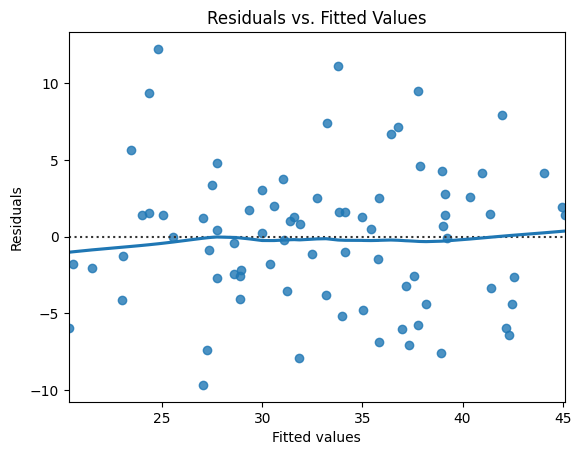

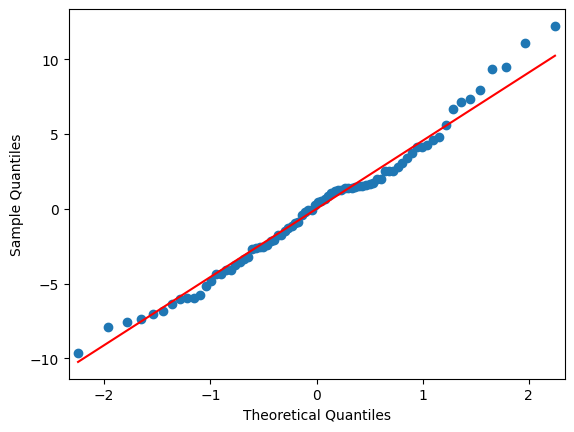

Shapiro-Wilk test statistic: 0.9835345512659741
Shapiro-Wilk p-value: 0.3942912178947833


In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import FTestAnovaPower

# Synthetic data generation
np.random.seed(42)

# Define sample sizes
n1 = 40  # Sample size for Experiment1
n2 = 40  # Sample size for Experiment2

# Generate metric A
A1 = np.random.normal(50, 10, n1)
A2 = np.random.normal(55, 10, n2)

# Generate metric B with some group effect
B1 = 0.5 * A1 + np.random.normal(0, 5, n1) + 5
B2 = 0.5 * A2 + np.random.normal(0, 5, n2) + 10

# Create DataFrames
df1 = pd.DataFrame({"A": A1, "B": B1, "Group": "Experiment1"})
df2 = pd.DataFrame({"A": A2, "B": B2, "Group": "Experiment2"})

# Combine DataFrames
df = pd.concat([df1, df2], ignore_index=True)
df["Group"] = df["Group"].astype("category")

# Visualize data
sns.scatterplot(data=df, x="A", y="B", hue="Group")
plt.title("Scatter plot of B vs. A by Group")
plt.show()

# Test for homogeneity of regression slopes
model_interaction = ols("B ~ A * Group", data=df).fit()
anova_table = sm.stats.anova_lm(model_interaction, typ=2)
print(anova_table)

# Check if interaction is significant
interaction_pvalue = anova_table["PR(>F)"]["A:Group"]
if interaction_pvalue > 0.05:
    print("Interaction not significant. Proceeding without interaction term.")
    # Perform ANCOVA without interaction term
    model = ols("B ~ A + Group", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)
else:
    print("Interaction significant. Including interaction term.")
    model = model_interaction  # Use model with interaction

# Analyze results
print(model.summary())

# Check assumptions
# Residuals vs. Fitted
fitted_vals = model.fittedvalues
residuals = model.resid
sns.residplot(x=fitted_vals, y=residuals, lowess=True)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

# Normality of residuals
sm.qqplot(residuals, line="s")
plt.show()
shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk test statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", shapiro_test.pvalue)

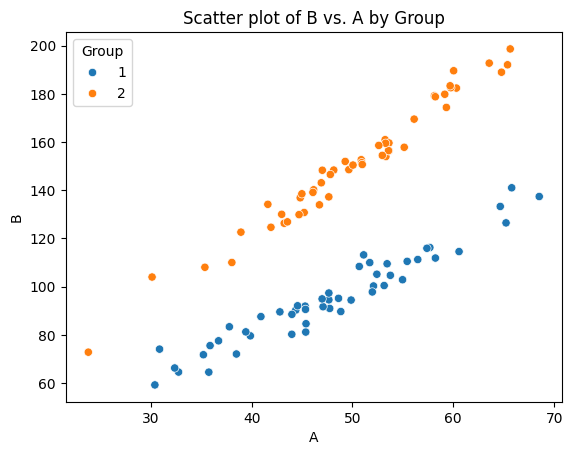

KeyError: 'Group_Experiment2'

In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Generate synthetic data
np.random.seed(42)

# Sample sizes
n1 = 50
n2 = 50

# Generate metric A
A1 = np.random.normal(50, 10, n1)
A2 = np.random.normal(50, 10, n2)

# Generate metric B
# Experiment1: B = 2*A + error
B1 = 2 * A1 + np.random.normal(0, 5, n1)

# Experiment2: B = 3*A + error
B2 = 3 * A2 + np.random.normal(0, 5, n2)

# Create DataFrames
df1 = pd.DataFrame({"A": A1, "B": B1})
df2 = pd.DataFrame({"A": A2, "B": B2})

# Add Group indicator
df1["Group"] = 1
df2["Group"] = 2

# Combine DataFrames
df = pd.concat([df1, df2], ignore_index=True)
df["Group"] = df["Group"].astype("category")

# Visualize data
sns.scatterplot(data=df, x="A", y="B", hue="Group")
plt.title("Scatter plot of B vs. A by Group")
plt.show()

# Encode the Group variable
df = pd.get_dummies(df, columns=["Group"], drop_first=True)

# Create interaction term
df["A_Group"] = df["A"] * df["Group_Experiment2"]

# Define independent variables
X = df[["A", "Group_Experiment2", "A_Group"]]
X = sm.add_constant(X)

# Define dependent variable
y = df["B"]

# Fit regression model
model = sm.OLS(np.asarray(y), X).fit()

# View model summary
print(model.summary())

# Check assumptions
# Residuals vs. Fitted
fitted_vals = model.fittedvalues
residuals = model.resid
sns.residplot(x=fitted_vals, y=residuals, lowess=True)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

# Normality of residuals
sm.qqplot(residuals, line="45")
plt.show()
shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk test statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", shapiro_test.pvalue)

# Homoscedasticity
bp_test = het_breuschpagan(residuals, X)
print("Breusch-Pagan test statistic:", bp_test[0])
print("Breusch-Pagan p-value:", bp_test[1])

# Multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

# Visualize regression lines
# Need to map Group_Experiment2 back to original group labels for plotting
df["Group"] = df["Group_Experiment2"].map({0: "Experiment1", 1: "Experiment2"})
sns.lmplot(
    x="A", y="B", hue="Group", data=df, markers=["o", "x"], palette="Set1", ci=None
)
plt.title("Regression Lines for Each Group")
plt.show()

# Learning how to do cross partitioner comparison 2

## Try out some works

In [25]:
df.columns = ["metric_value", "test_acc", "partitioner"]

In [26]:
model_interaction = ols("test_acc ~ metric_value * partitioner", data=df).fit()
anova_table = sm.stats.anova_lm(model_interaction, typ=2)
print(anova_table)

                            sum_sq    df          F    PR(>F)
partitioner               0.000478   1.0   0.096358  0.757817
metric_value              0.107197   1.0  21.611896  0.000034
metric_value:partitioner  0.007482   1.0   1.508408  0.226386
Residual                  0.203364  41.0        NaN       NaN


                            sum_sq    df          F    PR(>F)
partitioner               0.000478   1.0   0.096358  0.757817
metric_value              0.107197   1.0  21.611896  0.000034
metric_value:partitioner  0.007482   1.0   1.508408  0.226386
Residual                  0.203364  41.0        NaN       NaN
Interaction not significant. Proceeding without interaction term.
                sum_sq    df          F    PR(>F)
partitioner   0.000478   1.0   0.095206  0.759186
metric_value  0.107197   1.0  21.353414  0.000036
Residual      0.210846  42.0        NaN       NaN
                            OLS Regression Results                            
Dep. Variable:               test_acc   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     11.23
Date:                Mon, 23 Sep 2024   Prob (F-statistic):           0.000124
Time:                        

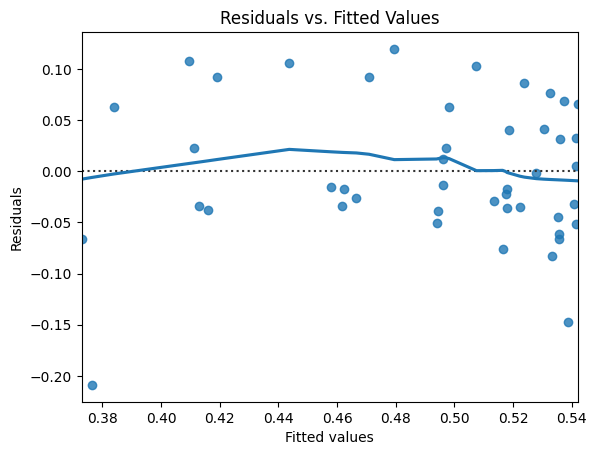

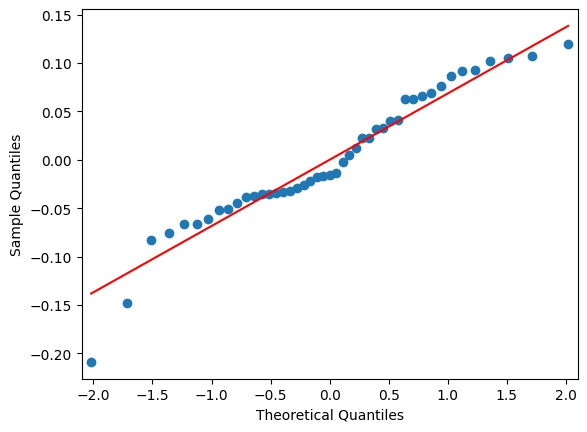

Shapiro-Wilk test statistic: 0.9534392876145992
Shapiro-Wilk p-value: 0.06861713345986872


In [29]:
anova_table = sm.stats.anova_lm(model_interaction, typ=2)
print(anova_table)

# Check if interaction is significant
interaction_pvalue = anova_table["PR(>F)"]["metric_value:partitioner"]
if interaction_pvalue > 0.05:
    print("Interaction not significant. Proceeding without interaction term.")
    # Perform ANCOVA without interaction term
    model = ols("test_acc ~ metric_value + partitioner", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)
else:
    print("Interaction significant. Including interaction term.")
    model = model_interaction  # Use model with interaction

# Analyze results
print(model.summary())

# Check assumptions
# Residuals vs. Fitted
fitted_vals = model.fittedvalues
residuals = model.resid
sns.residplot(x=fitted_vals, y=residuals, lowess=True)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

# Normality of residuals
sm.qqplot(residuals, line="s")
plt.show()
shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk test statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", shapiro_test.pvalue)

<Axes: ylabel='Frequency'>

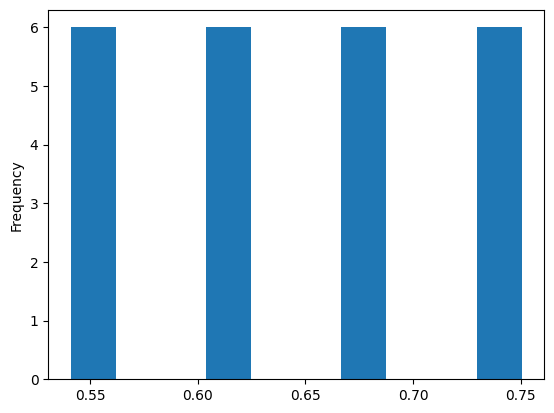

In [29]:
pathological_df["metric_value"].plot.hist()

<Axes: ylabel='Frequency'>

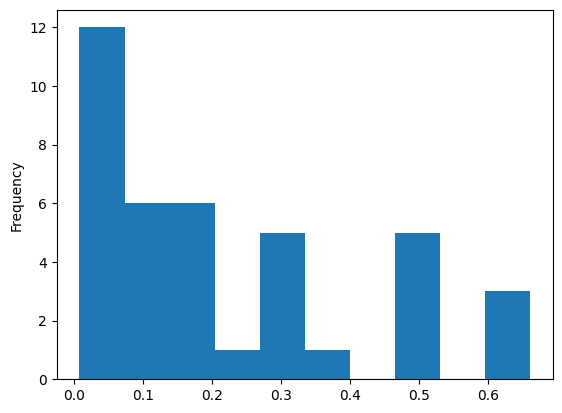

In [30]:
dirichlet_df["metric_value"].plot.hist()

In [31]:
pathological_df["bin"] = pd.cut(
    pathological_df.loc[:, "metric_value"],
    bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    labels=False,
).astype(int)
dirichlet_df["bin"] = pd.cut(
    dirichlet_df.loc[:, "metric_value"],
    bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    labels=False,
).astype(int)

/tmp/ipykernel_645623/1110265417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df['bin'] = pd.cut(dirichlet_df.loc[:, 'metric_value'],  bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], labels=False).astype(int)


<Axes: xlabel='bin'>

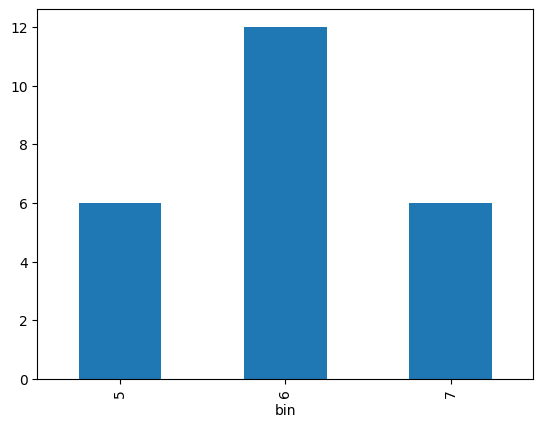

In [34]:
pathological_df["bin"].value_counts().sort_index().plot.bar()

<Axes: xlabel='bin'>

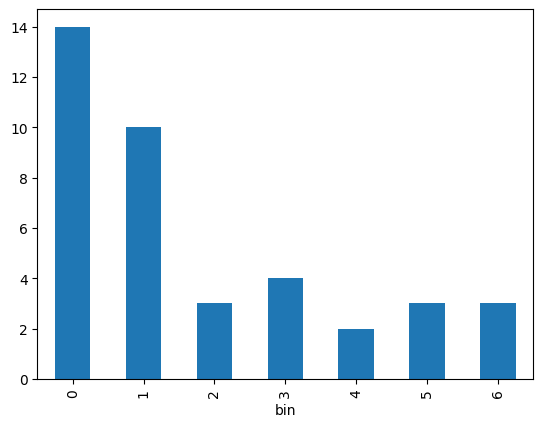

In [35]:
dirichlet_df["bin"].value_counts().sort_index().plot.bar()

In [36]:
# Calculate the correlation for each common bin value
correlations = []
for bin_value in range(5, 6):
    pathological_bin = pathological_df[pathological_df["bin"] == bin_value]
    dirichlet_bin = dirichlet_df[dirichlet_df["bin"] == bin_value]
    correlation = pathological_bin["eval/acc"].corr(dirichlet_bin["eval/acc"])
    correlations.append(correlation)

correlations = np.array(correlations)

# Print the correlations
print(correlations)

[nan]


In [49]:
pathological_df[pathological_df["bin"] == bin_value]["eval/acc"]

3     0.8682
7     0.9827
11    0.9809
15    0.9831
19    0.9719
23    0.9519
Name: eval_acc, dtype: float64

In [52]:
dirichlet_df[dirichlet_df["bin"] == bin_value]["eval/acc"]

0     0.8843
22    0.9713
29    0.9670
Name: eval_acc, dtype: float64

In [37]:
dirichlet_df

,num_partitions,alpha,eval_acc,metric_value,bin
0,3,0.1,0.8843,0.520301,5
1,3,0.3,0.9863,0.388463,3
2,3,1.0,0.9874,0.250478,2
3,3,3.0,0.9886,0.141928,1
4,3,10.0,0.9907,0.078216,0
5,3,100.0,0.9913,0.025358,0
6,3,1000.0,0.9910,0.008000,0
7,10,0.1,0.9174,0.620323,6
8,10,0.3,0.9888,0.482991,4
9,10,1.0,0.9893,0.282998,2


In [38]:
pathological_df

,num_partitions,num_classes_per_partition,eval_acc,metric_value,bin
0,3,2,0.5725,0.743239,7
1,3,3,0.6383,0.680142,6
2,3,4,0.6797,0.618636,6
3,3,5,0.8682,0.551557,5
4,10,2,0.6746,0.750358,7
5,10,3,0.9392,0.678988,6
6,10,4,0.9660,0.613246,6
7,10,5,0.9827,0.546469,5
8,30,2,0.4091,0.746112,7
9,30,3,0.3563,0.674386,6


In [39]:
pathological_bin

,num_partitions,num_classes_per_partition,eval_acc,metric_value,bin
3,3,5,0.8682,0.551557,5
7,10,5,0.9827,0.546469,5
11,30,5,0.9809,0.542557,5
15,100,5,0.9831,0.541341,5
19,300,5,0.9719,0.541064,5
23,1000,5,0.9519,0.541121,5


In [40]:
dirichlet_bin

,num_partitions,alpha,eval_acc,metric_value,bin
0,3,0.1,0.8843,0.520301,5
22,100,0.3,0.9713,0.507179,5
29,300,0.3,0.9670,0.512800,5


# Learn the cross partitioners works 3


Interaction terms:
[[5.48813504 1.         5.48813504]
 [7.15189366 0.         0.        ]
 [6.02763376 1.         6.02763376]
 [5.44883183 0.         0.        ]
 [4.23654799 0.         0.        ]
 [6.45894113 1.         6.45894113]
 [4.37587211 1.         4.37587211]
 [8.91773001 0.         0.        ]
 [9.63662761 0.         0.        ]
 [3.83441519 0.         0.        ]
 [7.91725038 1.         7.91725038]
 [5.2889492  1.         5.2889492 ]
 [5.68044561 0.         0.        ]
 [9.25596638 0.         0.        ]
 [0.71036058 0.         0.        ]
 [0.871293   0.         0.        ]
 [0.20218397 0.         0.        ]
 [8.32619846 1.         8.32619846]
 [7.78156751 0.         0.        ]
 [8.70012148 1.         8.70012148]
 [9.78618342 0.         0.        ]
 [7.99158564 0.         0.        ]
 [4.61479362 0.         0.        ]
 [7.80529176 1.         7.80529176]
 [1.18274426 1.         1.18274426]
 [6.39921021 1.         6.39921021]
 [1.43353287 0.         0.        ]
 [9.44668

/root/.pyenv/versions/3.10.9/envs/fl-heterogeneity/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/root/.pyenv/versions/3.10.9/envs/fl-heterogeneity/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


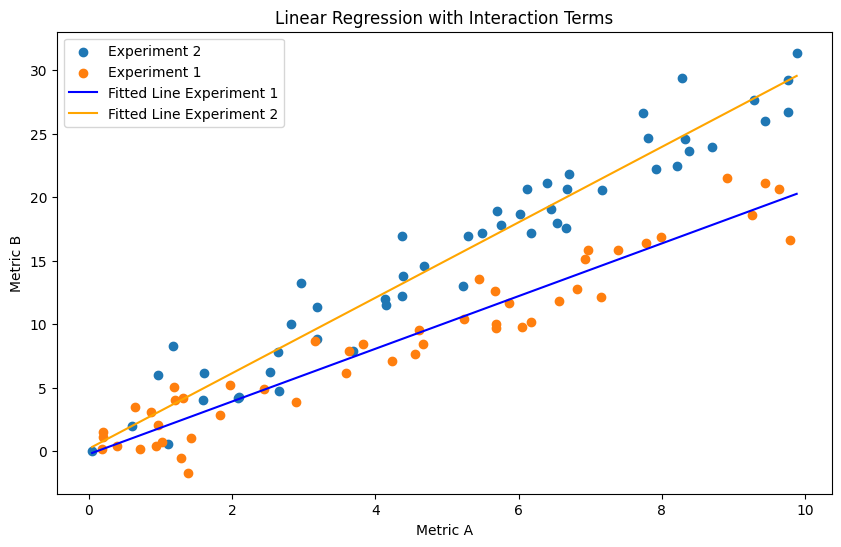

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Create a synthetic dataset
np.random.seed(0)
n_samples = 100
metric_a = np.random.uniform(0, 10, n_samples)
group = np.random.choice(["Experiment 1", "Experiment 2"], size=n_samples)
noise = np.random.normal(0, 2, n_samples)
metric_b = np.where(group == "Experiment 1", 2 * metric_a + noise, 3 * metric_a + noise)
df = pd.DataFrame({"Metric_A": metric_a, "eval/acc": eval / acc, "Group": group})

# 2. Encode the Group variable
encoder = OneHotEncoder(drop="first", sparse_output=False)
group_encoded = encoder.fit_transform(df[["Group"]])
encoded_feature_names = encoder.get_feature_names_out(["Group"])
df_group_encoded = pd.DataFrame(group_encoded, columns=encoded_feature_names)
df_encoded = pd.concat([df.reset_index(drop=True), df_group_encoded], axis=1)
df_encoded.drop("Group", axis=1, inplace=True)

# 3. Create interaction terms
X = df_encoded[["Metric_A", "Group_Experiment 2"]]
y = df_encoded["Metric_B"]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction_terms = poly.fit_transform(X)
print("Interaction terms:")
print(interaction_terms)
feature_names = poly.get_feature_names_out(["Metric_A", "Group_Experiment 2"])
df_interactions = pd.DataFrame(interaction_terms, columns=feature_names)
df_final = pd.concat([df_interactions, y.reset_index(drop=True)], axis=1)

# 4. Define X and y
X = df_final.drop("Metric_B", axis=1)
y = df_final["Metric_B"]

# 5. Split the data (optional)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6. Fit the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# 7. Print coefficients
coefficients = pd.DataFrame({"Feature": X.columns, "Coefficient": model.coef_})
print(coefficients)
print(f"Intercept: {model.intercept_}")

# 8. Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# 9. Visualize the results
plt.figure(figsize=(10, 6))
for grp in df["Group"].unique():
    idx = df["Group"] == grp
    plt.scatter(df.loc[idx, "Metric_A"], df.loc[idx, "Metric_B"], label=grp)
metric_a_range = np.linspace(df["Metric_A"].min(), df["Metric_A"].max(), 100)
group_exp1 = np.zeros_like(metric_a_range)
interaction_exp1 = metric_a_range * group_exp1
X_plot_exp1 = np.column_stack([metric_a_range, group_exp1, interaction_exp1])
y_plot_exp1 = model.predict(X_plot_exp1)
group_exp2 = np.ones_like(metric_a_range)
interaction_exp2 = metric_a_range * group_exp2
X_plot_exp2 = np.column_stack([metric_a_range, group_exp2, interaction_exp2])
y_plot_exp2 = model.predict(X_plot_exp2)
plt.plot(metric_a_range, y_plot_exp1, color="blue", label="Fitted Line Experiment 1")
plt.plot(metric_a_range, y_plot_exp2, color="orange", label="Fitted Line Experiment 2")
plt.xlabel("Metric A")
plt.ylabel("Metric B")
plt.title("Linear Regression with Interaction Terms")
plt.legend()
plt.show()

                       Feature  Coefficient
0                     Metric_A     1.902198
1           Group_Experiment 2    -0.088381
2           Group_Experiment 3    -0.823880
3  Metric_A Group_Experiment 2     1.098401
4  Metric_A Group_Experiment 3     2.202400
Intercept: 0.12173576473566605
Mean Squared Error: 3.1376
R^2 Score: 0.9635


/root/.pyenv/versions/3.10.9/envs/fl-heterogeneity/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/root/.pyenv/versions/3.10.9/envs/fl-heterogeneity/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/root/.pyenv/versions/3.10.9/envs/fl-heterogeneity/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


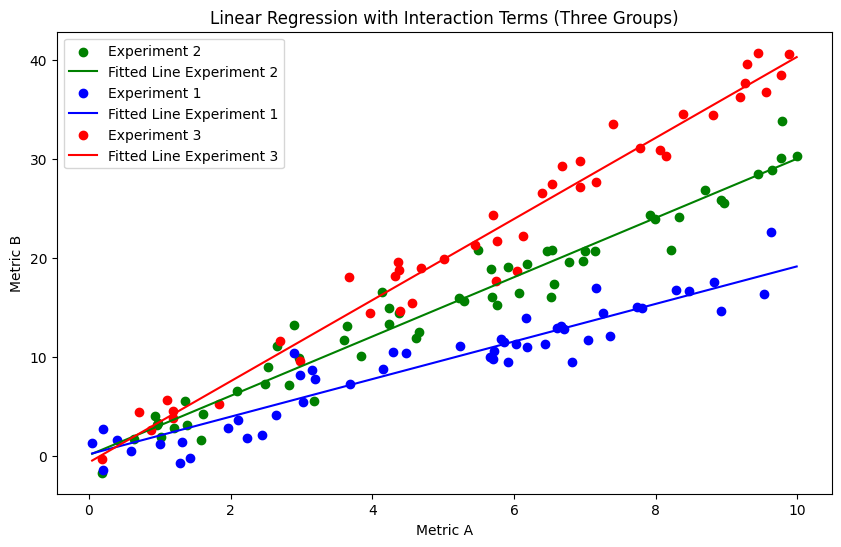

In [13]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Create a synthetic dataset with three groups
np.random.seed(0)
n_samples = 150
metric_a = np.random.uniform(0, 10, n_samples)
group = np.random.choice(
    ["Experiment 1", "Experiment 2", "Experiment 3"], size=n_samples
)
noise = np.random.normal(0, 2, n_samples)
metric_b = np.where(
    group == "Experiment 1",
    2 * metric_a + noise,
    np.where(group == "Experiment 2", 3 * metric_a + noise, 4 * metric_a + noise),
)
df = pd.DataFrame({"Metric_A": metric_a, "Metric_B": metric_b, "Group": group})

# 2. Encode the Group variable
encoder = OneHotEncoder(drop="first", sparse_output=False)
group_encoded = encoder.fit_transform(df[["Group"]])
encoded_feature_names = encoder.get_feature_names_out(["Group"])
df_group_encoded = pd.DataFrame(group_encoded, columns=encoded_feature_names)
df_encoded = pd.concat([df.reset_index(drop=True), df_group_encoded], axis=1)
df_encoded.drop("Group", axis=1, inplace=True)

# 3. Create interaction terms
X = df_encoded[["Metric_A"] + list(encoded_feature_names)]
y = df_encoded["Metric_B"]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)
feature_names = poly.get_feature_names_out(["Metric_A"] + list(encoded_feature_names))
df_features = pd.DataFrame(X_poly, columns=feature_names)
df_final = pd.concat([df_features, y.reset_index(drop=True)], axis=1)

# 4. Prepare feature matrix and target vector
X = df_features.drop(["Group_Experiment 2 Group_Experiment 3"], axis=1)
y = df_final["Metric_B"]

# 5. Split the data (optional)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6. Fit the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# 7. Print coefficients
coefficients = pd.DataFrame({"Feature": X.columns, "Coefficient": model.coef_})
print(coefficients)
print(f"Intercept: {model.intercept_}")

# 8. Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# 9. Visualize the results
colors = {"Experiment 1": "blue", "Experiment 2": "green", "Experiment 3": "red"}
plt.figure(figsize=(10, 6))
for grp in df["Group"].unique():
    idx = df["Group"] == grp
    plt.scatter(
        df.loc[idx, "Metric_A"], df.loc[idx, "Metric_B"], label=grp, color=colors[grp]
    )
    metric_a_range = np.linspace(df["Metric_A"].min(), df["Metric_A"].max(), 100)
    group_encoded = encoder.transform([[grp]]).flatten()
    group_experiment_2 = (
        group_encoded[0] if "Group_Experiment 2" in encoded_feature_names else 0
    )
    group_experiment_3 = (
        group_encoded[1] if "Group_Experiment 3" in encoded_feature_names else 0
    )
    metric_a_group_2 = metric_a_range * group_experiment_2
    metric_a_group_3 = metric_a_range * group_experiment_3
    X_plot = pd.DataFrame(
        {
            "Metric_A": metric_a_range,
            "Group_Experiment 2": group_experiment_2,
            "Group_Experiment 3": group_experiment_3,
            "Metric_A Group_Experiment 2": metric_a_group_2,
            "Metric_A Group_Experiment 3": metric_a_group_3,
        }
    )
    y_plot = model.predict(X_plot)
    plt.plot(metric_a_range, y_plot, color=colors[grp], label=f"Fitted Line {grp}")
plt.xlabel("Metric A")
plt.ylabel("Metric B")
plt.title("Linear Regression with Interaction Terms (Three Groups)")
plt.legend()
plt.show()

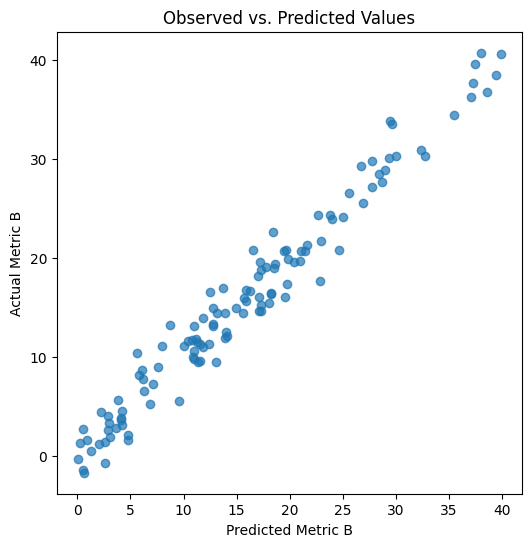

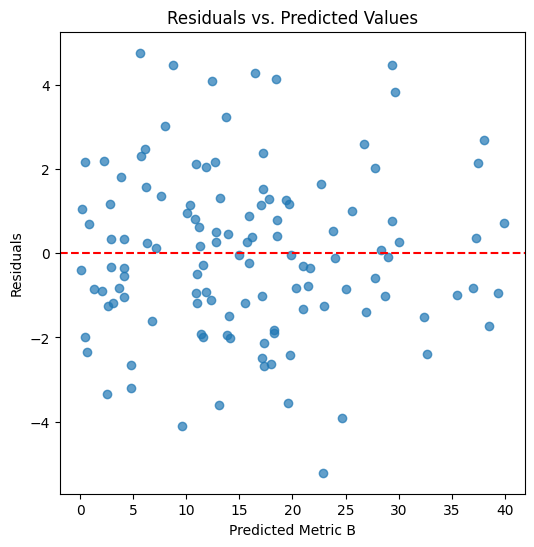

In [26]:
# Predict on the training set
y_train_pred = model.predict(X_train)

# Plot observed vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_train_pred, y_train, alpha=0.7)
plt.xlabel("Predicted Metric B")
plt.ylabel("Actual Metric B")
plt.title("Observed vs. Predicted Values")
plt.show()

# Plot residuals vs. predicted values
residuals = y_train - y_train_pred
plt.figure(figsize=(6, 6))
plt.scatter(y_train_pred, residuals, alpha=0.7)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Metric B")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()

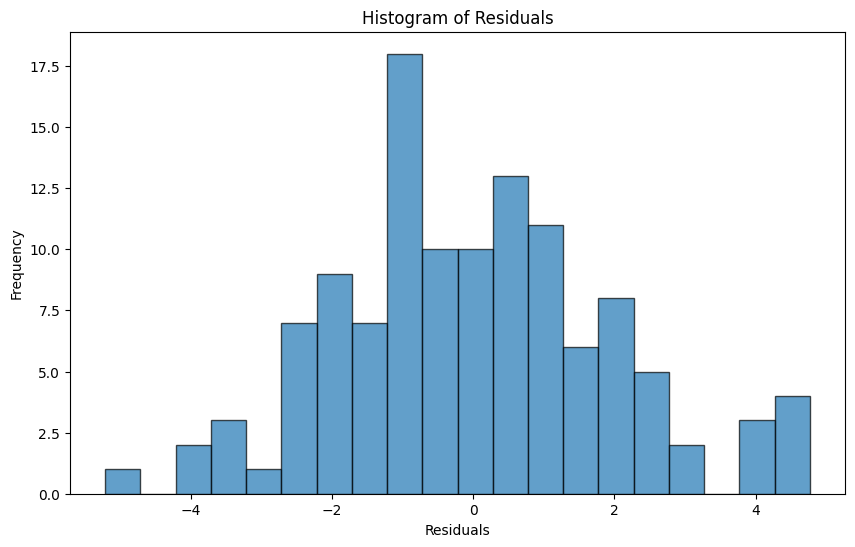

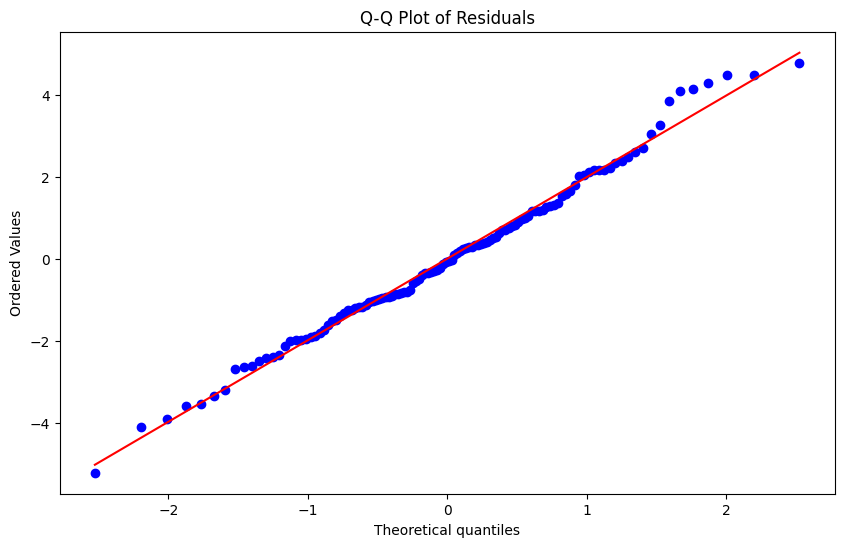

Shapiro-Wilk Test Statistic: 0.9906, p-value: 0.5921


In [27]:
import scipy.stats as stats

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, edgecolor="k", alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

# Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Shapiro-Wilk test
shapiro_test = stats.shapiro(residuals)
print(
    f"Shapiro-Wilk Test Statistic: {shapiro_test.statistic:.4f}, p-value: {shapiro_test.pvalue:.4f}"
)

In [28]:
# Add an intercept term to X_train
import numpy.linalg as la

# Number of observations and predictors
n = X_train.shape[0]
p = X_train.shape[1] + 1  # +1 for the intercept

# Add intercept to X_train
X_train_intercept = np.column_stack((np.ones(n), X_train.values))

# Calculate predictions and residuals
y_train_pred = model.predict(X_train)
residuals = y_train - y_train_pred

# Estimate of the variance of the residuals
s_squared = np.sum(residuals**2) / (n - p)

# Calculate the covariance matrix of the coefficients
XTX_inv = la.inv(np.dot(X_train_intercept.T, X_train_intercept))
cov_beta = s_squared * XTX_inv

# Standard errors of the coefficients
standard_errors = np.sqrt(np.diag(cov_beta))

# Coefficient estimates (including intercept)
coefficients = np.concatenate(([model.intercept_], model.coef_))

# t-statistics
t_stats = coefficients / standard_errors

# Degrees of freedom
df = n - p

# Two-tailed p-values
p_values = [2 * (1 - stats.t.cdf(np.abs(t), df)) for t in t_stats]

# Create a DataFrame to display results
coef_summary = pd.DataFrame(
    {
        "Coefficient": coefficients,
        "Standard Error": standard_errors,
        "t-value": t_stats,
        "p-value": p_values,
    },
    index=["Intercept"] + list(X_train.columns),
)

print(coef_summary)

                             Coefficient  Standard Error    t-value  \
Intercept                       0.121736        0.646841   0.188201   
Metric_A                        1.902198        0.115467  16.473932   
Group_Experiment 2             -0.088381        0.918820  -0.096189   
Group_Experiment 3             -0.823880        0.958576  -0.859483   
Metric_A Group_Experiment 2     1.098401        0.159251   6.897311   
Metric_A Group_Experiment 3     2.202400        0.161862  13.606635   

                                  p-value  
Intercept                    8.510541e-01  
Metric_A                     0.000000e+00  
Group_Experiment 2           9.235390e-01  
Group_Experiment 3           3.918776e-01  
Metric_A Group_Experiment 2  3.133667e-10  
Metric_A Group_Experiment 3  0.000000e+00  
